# How to interpolate drifter positions and times on ERA5 stress fields?

In [1]:
import cfgrib
import xarray as xr
import numpy as np
import os
# for some dask/distributed verison
# from dask.distributed import Client, LocalCluster 

I was working on my laptop but running this notebook on my desktop
I could not figure out how to link the local server on my desktop to the dask tab in this notebook. Any clue?

In [7]:
# client = Client("tcp://127.0.0.1:53892")
# client
# cluster = LocalCluster(n_workers=4, 
#                        threads_per_worker=1,
#                        memory_limit='32GB')
# client = Client(cluster)

# cluster.close()

# from dask.distributed import Client

# client = Client("tcp://127.0.0.1:49435")
# client

## 1. Exploring the ERA5 stress data

In [2]:
# under macOS Monterey, google drive has an impossible path
dirpath = '/Volumes/GoogleDrive-100185530479395605261/My Drive/CloudDrift/data/'
# what is the best approach? open a multi file dataset?

In [3]:
# just trying to tie 2 months for this example. I have downloaded the ERA5 stress data in sets of months
# each month is ~ 2.9GB
file1 = 'era5_stress_201707.grib'
file2 = 'era5_stress_201708.grib'

In [4]:
# what should be the chunks?
# so this download locally the files from google
# these are stress data but the pangeo data cloud has 10-m winds
ds1 = xr.open_dataset(dirpath+file1,engine='cfgrib',chunks={})
ds2 = xr.open_dataset(dirpath+file2,engine='cfgrib',chunks={})

In [5]:
ds1

<xarray.Dataset>
Dimensions:     (time: 63, step: 12, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2017-06-30T18:00:00 ... 2017-07-31T18:0...
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 11:00:00 12:00:00
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time, step) datetime64[ns] dask.array<chunksize=(63, 12), meta=np.ndarray>
Data variables:
    ewss        (time, step, latitude, longitude) float32 dask.array<chunksize=(63, 12, 721, 1440), meta=np.ndarray>
    nsss        (time, step, latitude, longitude) float32 dask.array<chunksize=(63, 12, 721, 1440), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-03-23T12:50 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
ds2

<xarray.Dataset>
Dimensions:     (time: 63, step: 12, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2017-07-31T18:00:00 ... 2017-08-31T18:0...
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 11:00:00 12:00:00
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time, step) datetime64[ns] dask.array<chunksize=(63, 12), meta=np.ndarray>
Data variables:
    ewss        (time, step, latitude, longitude) float32 dask.array<chunksize=(63, 12, 721, 1440), meta=np.ndarray>
    nsss        (time, step, latitude, longitude) float32 dask.array<chunksize=(63, 12, 721, 1440), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-03-23T12:53 GRIB to CDM+CF via cfgrib-0.9.1...

I think the arrangement of the data here is of the ECMWF type *forecast*. As such, you have coordinate `time` which indicates a specific point in time at which a forecast starts (initialization time), and coordinate `step` which **always** indicates hours after the initialization time.

See [ERA5 terminology: analysis and forecast; time and steps; instantaneous and accumulated and mean rates and min/max parameters](https://confluence.ecmwf.int/pages/viewpage.action?pageId=85402030#ERA5terminology:analysisandforecast;timeandsteps;instantaneousandaccumulatedandmeanratesandmin/maxparameters-TimeandStep)

So here this means for ds1 that we start with initialization time `2017-06-30T18:00:00` and the steps from 1 to 12 makes it such that we have data at `2017-06-30T19:00:00` to `2017-07-01T06:00:00`. The next initialization time is `2017-07-01T06:00:00` and the 12 time steps is such that we have data at `2017-07-01T07:00:00` to `2017-07-01T18:00:00`, etc. The last initialization time of that month is `2017-07-31T18:00:00` with steps corresponding to `2017-07-31T19:00:00` to `2017-08-01T06:00:00`.

My experience with the Matlab toolbox nctoolbox-1.1.3 is very different: it returns only `valid_time`, not `time` and `steps`.

Steps are here in nanoseconds so the following shows the steps are from 1 hour to 12 hours

In [7]:
ds1.step.data/1e9/60/60

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
      dtype='timedelta64[ns]')

In [32]:
display(ds1.time.data[0:2])
display(ds1.time.data[-2:])
display(ds2.time.data[0:2])

array(['2017-06-30T18:00:00.000000000', '2017-07-01T06:00:00.000000000'],
      dtype='datetime64[ns]')

array(['2017-07-31T06:00:00.000000000', '2017-07-31T18:00:00.000000000'],
      dtype='datetime64[ns]')

array(['2017-07-31T18:00:00.000000000', '2017-08-01T06:00:00.000000000'],
      dtype='datetime64[ns]')

However, we see that for the month of July, the first 5 data points are `nan` such that the data effectively 
start on July 1 at midnight. And the last 7 data points are also `nan` such that we have 
data points only until 2017-07-31T23:00:00

In [47]:
# dum = ds1.ewss[0,:,360,719].values
#dum2 = ds1.ewss[:,:,360,720-1].data.reshape(63*12)
#ds1.ewss[:,:,360,720-1].data.reshape(63*12)

In [50]:
# something that drives me nuts in python/xarray is how to actually display values
display(ds1.ewss[0,:,360,719].values)

array([       nan,        nan,        nan,        nan,        nan,
       -59.41797 , -54.277344, -46.41797 , -39.10547 , -33.160156,
       -30.460938, -32.617188], dtype=float32)

In [51]:
display(ds1.ewss[-1,:,360,719].values)

array([-223.72656, -244.25   , -251.40625, -230.29297, -195.64844,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan], dtype=float32)

In [55]:
#try to plot time series
#ewss and nsss are (time, step, latitude, longitude)
#foo1 = ds1.ewss[0,:,360,720-1]
#foo2 = ds1.ewss[-1,:,360,720-1]

Try to plot by rearranging the data?

In [56]:
import matplotlib.pyplot as plt

In [59]:
# time series of stress at one location
foo1 = ds1.ewss[:,:,360,720-1]

In [60]:
foo1

<xarray.DataArray 'ewss' (time: 63, step: 12)>
dask.array<getitem, shape=(63, 12), dtype=float32, chunksize=(63, 12), chunktype=numpy.ndarray>
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2017-06-30T18:00:00 ... 2017-07-31T18:0...
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 11:00:00 12:00:00
    surface     float64 ...
    latitude    float64 0.0
    longitude   float64 179.8
    valid_time  (time, step) datetime64[ns] dask.array<chunksize=(63, 12), meta=np.ndarray>
Attributes:
    GRIB_paramId:                             180
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    GRIB_gridType:                            regular_ll
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              surface_downward_eastward_stress
    GRIB_cfVarName:                           ewss
    GRIB_gridDefinitionDescription:           Latitude/Longitude Grid
    GRIB_iDirectionIncrementInDegrees:        0.25
    GRIB_iScansNegatively:                    0
    GRIB_jDirectionIncrementInDegrees:        0.25
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   90.0
    GRIB_latitudeOfLastGridPointInDegrees:    -90.0
    GRIB_longitudeOfFirstGridPointInDegrees:  0.0
    GRIB_longitudeOfLastGridPointInDegrees:   359.75
    GRIB_missingValue:                        9999
    GRIB_name:                                Eastward turbulent surface stress
    GRIB_shortName:                           ewss
    GRIB_totalNumber:                         0
    GRIB_units:                               N m**-2 s
    long_name:                                Eastward turbulent surface stress
    units:                                    N m**-2 s
    standard_name:                            surface_downward_eastward_stress

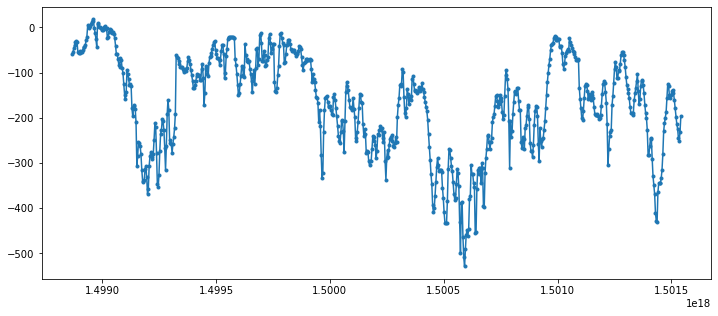

In [61]:
fig, ax = plt.subplots(figsize=(12,5))
#ax.plot(foo1.valid_time[:],foo1.data[:],marker='.',linestyle='none')
ax.plot(foo1.valid_time.data.reshape(63*12),foo1.data.reshape(63*12),marker='.',linestyle='-')

In [62]:
#t1 = foo1.valid_time.data.reshape(63*12)
#d1 = foo1.data.reshape(63*12)

In [63]:
#np.diff(t1)/1e9/60/60
#yes the time step is 1 hour

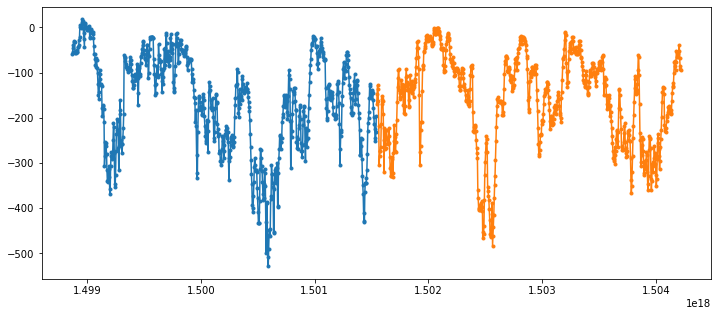

In [64]:
# plot two months
# the coordinate valid_time seems to be the one to use
fig, ax = plt.subplots(figsize=(12,5))
#ax.plot(foo1.valid_time[:],foo1.data[:],marker='.',linestyle='none')
ax.plot(ds1.ewss[:,:,360,720-1].valid_time.data.reshape(63*12),ds1.ewss[:,:,360,720-1].data.reshape(63*12),marker='.',linestyle='-')
ax.plot(ds2.ewss[:,:,360,720-1].valid_time.data.reshape(63*12),ds2.ewss[:,:,360,720-1].data.reshape(63*12),marker='.',linestyle='-')


In [69]:
# how do I actually display the values???? drives me nuts :)
display(ds1.ewss[0,:,360,720-1].valid_time.data)

dask.array<getitem, shape=(12,), dtype=datetime64[ns], chunksize=(12,), chunktype=numpy.ndarray>

In [70]:
# do I need to define new variables to be able to display the values?
dum1 = ds1.ewss[:,:,360,720-1].valid_time.data.reshape(63*12)
dum2 = ds1.ewss[:,:,360,720-1].data.reshape(63*12)

In [74]:
# how do I get the values?
type(dum2)

dask.array.core.Array

In [79]:
dum2

dask.array<reshape, shape=(756,), dtype=float32, chunksize=(756,), chunktype=numpy.ndarray>

## 2. Interpolation

Next: load in the drifter positions, reshape the era5 stress before interpolating? load multiple file dataset? How to set the chunks?